# Implementing a Learning Rate Finder from Scratch
> Choosing the right learning rate is important for DNNs. In this post we implement a Learning Rate Finder from scratch, taking inspiration from Leslie Smith's LR range test--a technique implemented in popular libraries and frameworks such as fastai to find optimal learning rates to train a model. 

- toc: true
- badges: true
- comments: true
- categories: [machine-learning]
- image: images/lrf-from-scratch.png
- keywords: machine learning, ml, learning rate, learning rate finder, lr finder, lr_finder, lr_find, deep neural network, neural network, convolutional neural network, beginner concepts, fastai, fast.ai, pytorch

In [ ]:
#hide
!pip install -Uq fastbook
from fastbook import *

     |████████████████████████████████| 727kB 7.3MB/s 
     |████████████████████████████████| 1.1MB 15.4MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 194kB 29.4MB/s 
     |████████████████████████████████| 61kB 9.5MB/s 


## Introduction

In this post we will implement a **learning rate finder** from scratch. A learning rate finder helps us find sensible learning rates for our models to train with, including minimum and maximum values to use in a **cyclical learning rate** policy. Both concepts were invented by Leslie Smith and I suggest you check out his [paper](https://arxiv.org/pdf/1506.01186.pdf){% fn 1 %}!

We'll implement the learning rate finder (and cyclical learning rates in a future post) into our Deep Neural Network created from scratch in the 2-part series [Implementing a Deep Neural Network from Scratch]({% post_url 2020-12-28-Implementing-a-Deep-Neural-Network-from-Scratch-Part-1 %}). Check that out first if you haven't read it already!

## Understanding the Learning Rate

Before we start, what _is_ the learning rate? The learning rate is just a value we multiply our gradients by in Stochastic Gradient Descent before updating our parameters with those values. Think of it like a "weight" that reduces the impact of each step change so as to ensure we are not over-shooting our loss function. If you imagine our loss function like a parabola, and our parameters starting somehwere along the parabola, descending along by a specific amount will bring us further "down" in the parabola, to it's minimum point eventually. If the step amount is too big however, we risk overshooting that minimum point. That's where the learning rate comes into play: it helps us achieve very small steps if desired.

To refresh your memory, here is what happens in the optimization step of Stochastic Gradient Descent ([Part 1]({% post_url 2020-12-28-Implementing-a-Deep-Neural-Network-from-Scratch-Part-1 %}) of our DNN series explains this formula in more detail, so read that first):

$ w := w - \eta \nabla Q({w}) $

Our parameter $w$ is updated by subtracting its gradient calculated with respect to the loss function $\nabla Q({w})$ after multiplying it by a weighing factor $\eta$. That weighing factor $\eta$ is our learning rate!

It's even easier in code:

```python
# part of the .step() method in our SGD_Optimizer
for p in self.parameters: p.data -= p.grad.data * self.lr
```

This is outlined in the `.step` method of our optimizer (check the setup code in the next section).
As we saw towards the end of [Part 2]({% post_url 2021-01-01-Implementing-a-Deep-Neural-Network-from-Scratch-Part-2 %}) of our Implementing a Deep Neural Network from Scratch series, the learning rate has a _big_ impact on training for our model: the lower the learning rate, the more epochs required to reach a given accuracy, the higher the learning rate, the higher risk of overshooting (or never reaching) the minimum loss. There's a lot more factors at play that we cover in that series, but for now let's just consider the learning rate.

Another aspect of learning rates is that a single value is rarely optimal for the duration of the training. We could say that its efficacy **degrades over time** (time measured in batches/epochs). That's why common techniques include decreasing the learning rate by a step-wise fixed amount or by an exponentially decreasing amount during the course of the training. The logic being that as the model is further into training and is approaching the minimum loss, it needs less pronounced updates (steps), and therefore would benefit from smaller increments.


## The Learning Rate Finder

The **learning rate finder**, or more appropriately **learning rate _range_ finder**, is a method outlined in a [paper](https://arxiv.org/pdf/1506.01186.pdf) by Leslie Smith written in 2015[^1]. The paper introduces the concept of **cyclical learning rates** (i.e. repeatedly cycling between learning rates inbetween a set minimum and a maximum has shown to be effective for training--a method we will implement from scratch in a future post!) whereby the minimum and maximum values to cycle through are found by a function that Leslie Smith defines as the "_LR range test_". Here's what the author himself has to say about it:

> There is a simple way to estimate reasonable minimum
and maximum boundary values with one training run of the
network for a few epochs. It is a “LR range test”; run your
model for several epochs while letting the learning rate increase linearly between low and high LR values. This test
is enormously valuable whenever you are facing a new architecture or dataset.{% fn 1 %}


So where does the learning rate finder come into play? Well, it helps us find how learning rates affect our training loss, helping us spot a "sweet spot" of ranges that maximize the loss. That extremes of that range will also be  minimum and maximum values to use in the cyclical learning rates policy Leslie Smith outlines in his paper -- before we can implement cyclical learning rates, we need to implement a learning rate range finder!

To give you an idea of what we're trying to create, let's see [fast.ai](https://fastai1.fast.ai/callbacks.lr_finder.html)'s implementation, probably one of the first frameworks to implement this LR range test. fast.ai offers a convenient helper function called the Learning Rate Finder (`Learner.lr_finder()`) that helps us see the effect a variety of learning rates have on our model's training performance as well as suggest a `min_grad_lr` where the gradient of the training loss is steepest:

![image.png](images/lr_finder.png)

Let's implement something similar!

## Getting Started

Below is a recap of all the preparatory steps to setup our data pipeline. In order, we'll download the data, generate a list of file paths, create training and validation tensor stacks from the file paths, convert those tensors from rank-2 (2D matrix) tensors (i.e. size: 28, 28) to rank-1 (1D vector) tensors (i.e. size: 784). We'll then generate labels corresponding to the digit index and merge the input tensors and labels into datasets to create DataLoader. This will provide us with minibatches of sample data to run our SGD along.

In [ ]:
#collapse
# Requirements
# !pip install -Uq fastbook # includes all the common imports (plt, fastai, pytorch, etc)

# Download the data
path = untar_data(URLs.MNIST)

# Import the paths of our training and testing images
training = { f'{num}' : (path/f'training/{num}').ls().sorted() for num in range(10) }
testing = { f'{num}' : (path/f'testing/{num}').ls().sorted() for num in range(10) }

# Prepare training tensor stacks
training_tensors = [
      torch.stack([
            tensor(Image.open(digit)).float()/255 for digit in training[f'{num}']
          ]) for num in range(10)
      ]

validation_tensors = [
      torch.stack([
            tensor(Image.open(digit)).float()/255 for digit in testing[f'{num}']
          ]) for num in range(10)
      ]


# Convert our 2D image tensors (28, 28) into 1D vectors
train_x = torch.cat(training_tensors).view(-1, 28*28)
valid_x = torch.cat(validation_tensors).view(-1, 28*28)

# Generate our labels based on the digit each image represents
train_y = torch.from_numpy(np.concatenate([[i]*len(training[f'{i}']) for i in range(10)]))
valid_y = torch.from_numpy(np.concatenate([[i]*len(testing[f'{i}']) for i in range(10)]))

# Create datasets to feed into the dataloaders
dset = list(zip(train_x, train_y))
dset_valid = list(zip(valid_x, valid_y))

# Setup our dataloders
dl = DataLoader(dset, batch_size=256, shuffle=True)
valid_dl = DataLoader(dset_valid, batch_size=256, shuffle=True)


We'll also import the code that we created in our series on [Implementing a Deep Neural Network from Scratch](https://muttoni.github.io/blog/machine-learning/2020/12/28/Implementing-a-Deep-Neural-Network-from-Scratch-Part-1.html) in Python. The code we'll need is our general purpose `LinearModel`, our SGD optimizer `SGD_Optimizer` and our beloved `DeepClassifier`. Feel free to toggle the code below to see how each one works. 

In [ ]:
#collapse

# General purpose Linear Model
class LinearModel:
  def __init__(self, inputs, outputs,):
    self.input_size = inputs
    self.output_size = outputs
    self.weights, self.bias = self._init_params()

  def parameters(self):
    return self.weights, self.bias

  def model(self, x):
    return x@self.weights + self.bias

  def _init_params(self):
    weights = (torch.randn(self.input_size, self.output_size)).requires_grad_()
    bias = (torch.randn(self.output_size)).requires_grad_()
    return weights, bias


In [ ]:
#collapse

# General purpose SGD Optimizer
class SGD_Optimizer:
  def __init__(self, parameters, lr):
    self.parameters = list(parameters)
    self.lr = lr 
  
  def step(self):
    for p in self.parameters: p.data -= p.grad.data * self.lr
    for p in self.parameters: p.grad = None
    

In [ ]:
#collapse

# General Purpose Classifier
class DeepClassifier:
  """
  A multi-layer Neural Network using ReLU activations and SGD
  params: layers to use (LinearModels)
  methods: fit(train_dl, valid_dl, epochs, lr) and predict(image_tensor)
  """
  def __init__(self, *layers):
    self.accuracy_scores = []
    self.training_losses = []
    self.layers = layers

  def fit(self, **kwargs):
    self.train_dl = kwargs.get('train_dl')
    self.valid_dl = kwargs.get('valid_dl')
    self.epochs = kwargs.get('epochs', 5)
    self.lr = kwargs.get('lr', 0.1)
    self.verbose = kwargs.get('verbose', True)
    self.optimizers = []
    self.epoch_losses = []
    self.last_layer_index = len(self.layers)-1

    for layer in self.layers:
      self.optimizers.append(SGD_Optimizer(layer.parameters(),self.lr))

    for i in range(self.epochs):
      for xb, yb in self.train_dl:
        preds = self._forward(xb)
        self._backward(preds, yb)
  
      self._validate_epoch(i)

  def predict(self, image_tensor):
    probabilities = self._forward(image_tensor).softmax(dim=1)
    _, prediction = probabilities.max(-1)
    return prediction, probabilities

  def _forward(self, xb):
    res = xb
    for layer_idx, layer in enumerate(self.layers):
      if layer_idx != self.last_layer_index:
        res = layer.model(res)
        res = self._ReLU(res)
      else:
        res = layer.model(res)
    return res

  def _backward(self, preds, yb):
    loss = self._loss_function(preds, yb)
    self.epoch_losses.append(loss)
    loss.backward()
    for opt in self.optimizers: opt.step()

  def _batch_accuracy(self, xb, yb):
    predictions = xb.softmax(dim=1)
    _, max_indices = xb.max(-1)
    corrects = max_indices == yb 
    return corrects.float().mean() 

  def _validate_epoch(self, i):
    accs = [self._batch_accuracy(self._forward(xb), yb) for xb, yb in self.valid_dl]
    score = round(torch.stack(accs).mean().item(), 4)
    self.accuracy_scores.append(score)
    epoch_loss = round(torch.stack(self.epoch_losses).mean().item(), 4)
    self.epoch_losses = []
    self.training_losses.append(epoch_loss)
    self._print(f'Epoch #{i}', 'Loss:', epoch_loss, 'Accuracy:', score)

  def _loss_function(self, predictions, targets):
    log_sm_preds = torch.log_softmax(predictions, dim=1)
    idx = range(len(predictions))
    results = -log_sm_preds[idx, targets]
    return results.mean()

  def _ReLU(self, x):
    return x.max(tensor(0.0))

  def _print(self, *args):
    if self.verbose:
      print(*args)

**Note**: If you're looking for a walkthrough of the code above, make sure you read the 2 part series on implementing a deep neural network from scratch! I would especially focus on the second part. Here are the links: [Part 1]({% post_url 2020-12-28-Implementing-a-Deep-Neural-Network-from-Scratch-Part-1 %}), [Part 2]({% post_url 2021-01-01-Implementing-a-Deep-Neural-Network-from-Scratch-Part-2 %}).

## Requirements

Now that our code and model is setup, we need to recap what we need to add to our DeepClassifier in order to properly support a `lr_finder` method.

**Our goal**: a method called `lr_finder` that when called performs a round of training (aka fitting) for a predetermined number of epochs, starting with a very small learning rate, increasing it exponentially every minibatch (why exponentially? So that we have an equal representation of small learning rate values vs large ones -- more on this later). We can sort out specifics later. 


>Warning: The `lr_finder` can't start with random parameters, it should start with the current parameter state of the model, _without affecting it_ during training! So we'll need to **clone** our parameters.


We'll also need to update our code to keep track of training loss at every minibatch (across epochs), and store the respective learning rates used for each minibatch. 



Now, before we continue, I want to make a big **disclaimer**: the additions we'll make today are going to be "patches" added on to a codebase that is, to put it lightly, fragile. The code above was created for demonstration purposes only, and essentially contains the bare essentials to make a deep neural network classifier work properly. The sole use of this code, for me, is to tinker with it and try out ideas and concepts as I come across them.

While I'm tempted to re-write everything from scratch and build it into a more modular/generalized framework, it would introduce abstractions that for the purposes of our learning process would make "getting" the concepts more difficult, as effective abstractions inevitably hide away the lower level workings of a piece of code.

So I apologize for the entropy that we are about to introduce into this already "entropic" code. We might look into making it more robust in a future post. In the meantime, you are more than welcome to take this and refactor it to your liking!

With the disclaimer out of the way, let's recap how we normally used this DeepClassifier. We would instantiate the class and pass in the desired layers. Like so:

In [ ]:
my_nn = DeepClassifier(   # example usage
  LinearModel(28*28, 20), # a layer with 28*28 inputs (pixels), 20 activations
  LinearModel(20, 10)     # a layer with 20 inputs and 10 activations/outputs
)

Each layer contains the input and output parameter counts. Every layer's autput is ReLU'd automatically, except for the last one that uses Cross-Entropy Loss based on log and softmax. Read [Part 2]({% post_url 2021-01-01-Implementing-a-Deep-Neural-Network-from-Scratch-Part-2 %}) of the DNN from scratch series to see exactly how this works.

We then call the fit method and pass in the data, the learning rate and the epochs to train for:

In [ ]:
my_nn.fit(
    train_dl=train_dl, 
    valid_dl=valid_dl,
    lr=0.1,
    epochs=100
)

>Note: Note the limitations here: the learning rate is fixed--the very purpose of a learning rate finder is that it helps us map the effect of a _range_ of learning rates. Furthermore, the data is linked with the `fit` method, meaning that if we don't call `.fit`, we won't have any data inside our classifier.


So we must change our code to allow for data to be fed in at the instantiation stage of the DeepClassifier class. We'll also need to move some of the properties that we used to create in our `fit` method, at the instantiation step. First however, let's tweak our dependencies LinearModel and SGD_Optimizer.

### SGD_Optimizer

Given our learning rate needs to change over the course of each batch, we'll first need to be able to pass in a custom learning rate to our SGD optimizer's `step` method (where the updates are multiplied by the learning rate, as seen above). In our original code, the learning rate was set on instantiation and never touched again. We'll change it so the `step` method accepts a keyworded argument called `lr`, otherwise it defaults to its parameter `self.lr`.

In [ ]:
# General purpose SGD Optimizer
class SGD_Optimizer:
  def __init__(self, parameters, lr):
    self.parameters = list(parameters)
    self.lr = lr 
  
  def step(self, **kwargs):        # add **kawrgs
    lr = kwargs.get('lr', self.lr) # get 'lr' if set, otherwise set to self.lr
    for p in self.parameters: p.data -= p.grad.data * lr
    for p in self.parameters: p.grad = None

### LinearModel


In our `LinearModel` we need to introduce some changes. We need two new methods that our `lr_finder` can use to copy and set parameters so as not to overwrite the actual model parameters. We'll introduce two new methods: `copy_parameters` (note the `parameters` method already acts as a `get`), and a `set_parameters`. These are quite self-explanatory and the only tricky thing is to make sure to clone and detach any copies from the gradient calculations, as well as reset gradient tracking when setting the parameters. See the code below:

In [ ]:
#collapse_show
# General purpose Linear Model
class LinearModel:
  def __init__(self, inputs, outputs,):
    self.input_size = inputs
    self.output_size = outputs
    self.weights, self.bias = self._init_params()

  def parameters(self):
    return self.weights, self.bias

  def copy_parameters(self):
    return self.weights.clone().detach(), self.bias.clone().detach()

  def set_parameters(self, parameters):
    self.weights, self.bias = parameters
    self.weights.requires_grad_()
    self.bias.requires_grad_()

  def model(self, x):
    return x@self.weights + self.bias

  def _init_params(self):
    weights = (torch.randn(self.input_size, self.output_size)).requires_grad_()
    bias = (torch.randn(self.output_size)).requires_grad_()
    return weights, bias

## DeepClassifier

### Prep Work

Now we can proceed with updating DeepClassifier. We'll start by by changing our ``__init__`` method as follows:

In [ ]:
  def __init__(self, *layers, **kwargs): # added **kwargs
    self.layers = layers
    self.accuracy_scores = []
    self.training_losses = []

    # Moved all of the following from the 'fit' method
    self.optimizers = []
    self.epoch_losses = []
    self.train_dl = kwargs.get('train_dl', None)
    self.valid_dl = kwargs.get('valid_dl', None)
    self.lr = kwargs.get('lr', 1e-2)
    self.last_layer_index = len(self.layers)-1

    # We'll use this Boolean to determine whether to save
    # the individual batch losses in a list, instead of 
    # averaging them at every epoch. We need to do this 
    # as we'll need to plot them against each learning rate.
    self.save_batch_losses = False

    # if save_batch_losses is True, we save them here 
    self.batch_losses = []


We essentially moved a bunch of stuff from the `fit` method to the `__init__` method so as to be able to access them from our upcoming lr_finder method. You can read the code above to see what changed.

The backward method will need to accept an optional `lr` and pass it on to the step method of our optimizers. This allows us to feed in a dynamic learning rate. at each step function, which is exactly what we need.

We also have a `self.save_batch_losses` that flags whether our individual batch losses (that usually get aggregated and averaged per epoch) should be persisted at batch granularity in `self.batch_losses`. This is necessary with the lr_finder because we need to plot individual batch losses with individual learning rates that changed every batch.

In [ ]:
  def _backward(self, preds, yb, **kwargs):
    lr = kwargs.get('lr', self.lr)
    loss = self._loss_function(preds, yb)
    if self.save_batch_losses:
      self.batch_losses.append(loss.item())
    else:
      self.epoch_losses.append(loss)
    loss.backward()
    for opt in self.optimizers: opt.step(lr=lr)

### Implementing lr_finder()

Believe it or not, those are all the changes we need to make lr_finder work! Now we are to implement the new method. Here it is in all its glory, and we'll go line by line. 

In [ ]:
#collapse_show

  def lr_finder(self):
    base_lr = 1e-6
    max_lr = 1e+1
    epochs = 3
    current_lr = base_lr
    self.old_params = [layer.copy_parameters() for layer in self.layers]
    self.batch_losses = []
    self.lr_finder_lrs = []
    self.save_batch_losses = True

    batch_size = self.train_dl.bs
    samples = len(self.train_dl.dataset)
    iters = epochs * round(samples / batch_size)
    step_size = abs(math.log(max_lr/base_lr) / iters)

    print(batch_size, samples, iters, step_size)
    
    for layer in self.layers:
      self.optimizers.append(SGD_Optimizer(layer.parameters(), base_lr))

    while current_lr <= max_lr:
      for xb, yb in self.train_dl:
        if current_lr > max_lr:
          break
        preds = self._forward(xb)
        self._backward(preds, yb, lr=current_lr)
        self.lr_finder_lrs.append(current_lr)
        current_lr = math.e**(math.log(current_lr)+step_size*2)

    # clean up
    self.save_batch_losses = False
    self.optimizers = []
    for i in range(len(self.old_params)):
      self.layers[i].set_parameters(self.old_params[i])

Let's look at the code in detail:

```python
    base_lr = 1e-7
    max_lr = 1e+1
    epochs = 3
    current_lr = base_lr
```

Our brand new lr_finder method accepts a `base_lr` learning rate to start the range of experimentation. It will stop when it reaches `max_lr`. `epochs` is an arbitrary number that we set to determine how many epochs to run the finder for. We also set a `current_lr` to the minimum lr we want to test and this variable will be incremented at every step. The first three parameters are critical as they determine how many steps will be carried out, as the steps are determined by batch size, total sample size and epochs, like so:

```python
    batch_size = self.train_dl.bs
    samples = len(self.train_dl.dataset)
    iters = epochs * round(samples / batch_size)
    step_size = abs(math.log(max_lr/base_lr) / iters)
```

In my particular implementation, the step size `step_size` is determined by the range of learning rates to try out, divided by the iterations the model will go through (number of epochs multiplied by the number of batches in our sample). 

Now you may wonder why we are dividing the maximum learning rate by the minimum learning rate, instead of subtracting. The reason is: logs! Since we are dealing with logs, rather than do: $\frac{max\_lr - min\_lr}{iters}$, we do: $\frac{log(\frac{max\_lr}{min\_lr})}{iters}$. Rather than divide the learning rates linearly, which, when plotted on log scale, has the effect of condensing the majority of the learning rates towards the higher end, I opted to increment our step size exponentially. To do this we need to take the log so that we deal with exponents and can later increment the next learning rate by $e^{current\_lr+step\_size}$. This will ensure that when we plot our learning rates on a log scale, our iterations will be evenly spaced out.

```python
    self.old_params = [layer.copy_parameters() for layer in self.layers]
    self.lr_finder_lrs = []
    self.save_batch_losses = True
```

Next we save the old parameters so we can reset our model later. We create a list to store our learning rates and set the flag `save_batch_losses` to True, so that our _backward function knows to save them in our `batch_losses` list. The two lists `lr_finder_lrs` and `batch_losses` are the two lists that we will plot!

```python

    for layer in self.layers:
      self.optimizers.append(SGD_Optimizer(layer.parameters(), base_lr))

    while current_lr <= max_lr:
      for xb, yb in self.train_dl:
        if current_lr > max_lr:
          break
        preds = self._forward(xb)
        self._backward(preds, yb, lr=current_lr)
        self.lr_finder_lrs.append(current_lr)
        current_lr = math.e**(math.log(current_lr)+step_size)

```

Next we proceed as if we were a `fit` method, by initiating optimizers for each layer and going through our training cycle. As you can see, the loop is a little different, where we don't worry about epochs, we just check that the `current_lr` is less than or equal to the `max_lr`. We then go through each batch, apply `_forward`, then apply `_backward` and then make sure to save our current learning rate and update the learning rate for the next batch. Since our step_size is exponent-based (i.e. we logged it at the beginning, giving us the exponent of $e$ that will give us that value), we need to increment the exponent of $e$ by that step size. We do this by taking the log of our current learning rate and incrementing that by the step_size which is already logarithmic. 

The formula is as follows:
$ current\_lr = e^{log(current\_lr) + step\_size}$

Once our training rounds are complete, the last thing left to do is cleanup!

```python
    self.save_batch_losses = False
    self.optimizers = []
    for i in range(len(self.old_params)):
      self.layers[i].set_parameters(self.old_params[i])
```

We reset our flag `save_batch_losses`, reset our optimizers and copy back the saved parameters into the model. Again, the reason we want to save the parameters is so that we can apply the lr_finder at any stage of our fitting cycles without it affecting our parameter state.

Here is the updated DeepClassifier code:

In [ ]:
#collapse_show
class DeepClassifier:
  """
  A multi-layer Neural Network using ReLU activations and SGD
  params: layers to use (LinearModels)
  methods: 
    - fit(train_dl, valid_dl, epochs, lr)
    - predict(image_tensor)
    - lr_finder()
  """
  def __init__(self, *layers, **kwargs):
    self.layers = layers
    self.accuracy_scores = []
    self.training_losses = []
    self.optimizers = []
    self.epoch_losses = []
    self.batch_losses = []
    self.train_dl = kwargs.get('train_dl', None)
    self.valid_dl = kwargs.get('valid_dl', None)
    self.last_layer_index = len(self.layers)-1
    self.save_batch_losses = False
    self.lr = 0.1

  def fit(self, **kwargs):
    self.train_dl = kwargs.get('train_dl', self.train_dl)
    self.valid_dl = kwargs.get('valid_dl', self.valid_dl)
    self.epochs = kwargs.get('epochs', 5)
    self.lr = kwargs.get('lr', 0.1)
    self.verbose = kwargs.get('verbose', True)
    self.optimizers = []

    for layer in self.layers:
      self.optimizers.append(SGD_Optimizer(layer.parameters(),self.lr))

    for i in range(self.epochs):
      for xb, yb in self.train_dl:
        preds = self._forward(xb)
        self._backward(preds, yb)
  
      self._validate_epoch(i)

  def predict(self, image_tensor):
    probabilities = self._forward(image_tensor).softmax(dim=1)
    _, prediction = probabilities.max(-1)
    return prediction, probabilities

  def lr_finder(self):
    base_lr = 1e-6
    max_lr = 1e+1
    epochs = 3
    current_lr = base_lr
    self.old_params = [layer.copy_parameters() for layer in self.layers]
    self.lr_finder_lrs = []
    self.save_batch_losses = True

    batch_size = self.train_dl.bs
    samples = len(self.train_dl.dataset)
    iters = epochs * round(samples / batch_size)
    step_size = abs(math.log(max_lr/base_lr) / iters)
   
    for layer in self.layers:
      self.optimizers.append(SGD_Optimizer(layer.parameters(), base_lr))

    while current_lr <= max_lr:
      for xb, yb in self.train_dl:
        if current_lr > max_lr:
          break
        preds = self._forward(xb)
        self._backward(preds, yb, lr=current_lr)
        self.lr_finder_lrs.append(current_lr)
        current_lr = math.e**(math.log(current_lr)+step_size)

    # clean up
    self.save_batch_losses = False
    self.optimizers = []
    for i in range(len(self.old_params)):
      self.layers[i].set_parameters(self.old_params[i])

  def _forward(self, xb):
    res = xb
    for layer_idx, layer in enumerate(self.layers):
      if layer_idx != self.last_layer_index:
        res = layer.model(res)
        res = self._ReLU(res)
      else:
        res = layer.model(res)
    return res

  def _backward(self, preds, yb, **kwargs):
    lr = kwargs.get('lr', self.lr)
    loss = self._loss_function(preds, yb)
    if self.save_batch_losses:
      self.batch_losses.append(loss.item())
    else:
      self.epoch_losses.append(loss)
    loss.backward()
    for opt in self.optimizers: opt.step(lr=lr)

  def _batch_accuracy(self, xb, yb):
    predictions = xb.softmax(dim=1)
    _, max_indices = xb.max(-1)
    corrects = max_indices == yb 
    return corrects.float().mean() 

  def _validate_epoch(self, i):
    accs = [self._batch_accuracy(self._forward(xb), yb) for xb, yb in self.valid_dl]
    score = round(torch.stack(accs).mean().item(), 4)
    self.accuracy_scores.append(score)
    epoch_loss = round(torch.stack(self.epoch_losses).mean().item(), 4)
    self.epoch_losses = []
    self.training_losses.append(epoch_loss)
    self._print(f'Epoch #{i}', 'Loss:', epoch_loss, 'Accuracy:', score)

  def _loss_function(self, predictions, targets):
    log_sm_preds = torch.log_softmax(predictions, dim=1)
    idx = range(len(predictions))
    results = -log_sm_preds[idx, targets]
    return results.mean()

  def _ReLU(self, x):
    return x.max(tensor(0.0))

  def _print(self, *args):
    if self.verbose:
      print(*args)

## Demo

Now let's try it out! We instantiate a new `DeepClassifier` by specifying the layers and passing in the data so we can run our `lr_finder` before running `fit` (where in our old code we would normally feed in our dataset).

In [ ]:
my_nn = DeepClassifier(
  LinearModel(28*28, 20),
  LinearModel(20, 10),
  train_dl=dl,
  valid_dl=valid_dl
)

my_nn.lr_finder()

Now let's create a quick function to plot the results (this can easily be turned into a method as well, but beyond the scope of this post:

In [ ]:
def plot_lr_loss(my_nn):
  import matplotlib.pyplot as plt

  x = my_nn.lr_finder_lrs
  y = my_nn.batch_losses

  fig, ax = plt.subplots()

  ax.plot(x, y, 'g-')

  ax.set_xlabel('Learning Rates')
  ax.set_ylabel('Training Loss', color='g')
  plt.title(f"Results with lr={my_nn.lr}")
  plt.xscale('log')
  plt.show()


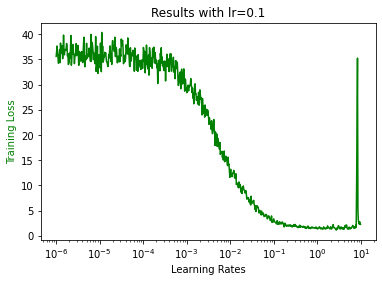

In [ ]:
plot_lr_loss(my_nn)

## Analyzing the lr_finder plot

As rules of thumb, fastai recommends picking the LR where the slope is steepest, or pick the end of the slop minimum and divide it by 10. In our case it seems our point of steepest slope is between $10^{-3}$ and $10^{-2}$. We definitely don't want to pick anything beyond 5e-1 as it seems the loss is flattening before picking up again. We also probably don't want to pick anything before $10^{-4}$ as the loss stays flat meaning it would take a lot of epochs before we see any significant improvement. If I were to pick a learning rate I would probably go with $10^{-2}$ for the first couple cycles, and then move to a finer one (e.g. $10^{-3}$).

## Conclusion

Learning rates are a critical part of training a neural network using SGD and a good learning rate will not only help you get closest to the minimum loss, but will also speed up your training (i.e. less epochs to reach a specific accuracy). 

Experiment with lr_finder yourself! Suggestions: try adding weights to our step_size increments (e.g. *2) and try incrementing it linearly instead of logarithmically and see how it affects the plot. 

If you have suggestions for what to implement next, comment below! Hope you found this useful and all the best in your machine learning journey. 

**References**

{{ 'Leslie N. Smith. (v6 2017, v1 2015). Cyclical Learning Rates for Training Neural Networks [Link](https://arxiv.org/abs/1506.01186)'  | fndetail: 1 }}
